In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# load cleaned data
df = pd.read_csv("data/HR_data_cleaned.csv")

In [4]:
df.columns

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Individu

In [168]:
# select features to use for clustering
cluster_cols = df.columns[0:1].append(df.columns[6:9]).append(df.columns[11:14])
print(cluster_cols)

Index(['HR_TD_Mean', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope', 'TEMP_TD_Mean', 'TEMP_TD_Median'],
      dtype='object')


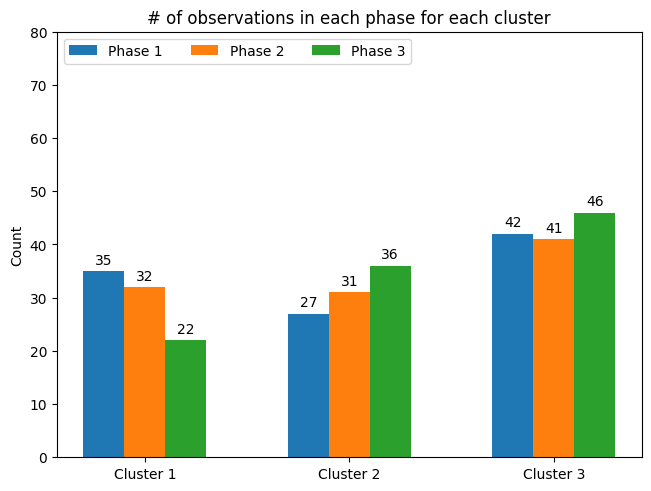

In [ ]:

# k means clustering
kmeans = KMeans(n_clusters=3).fit(df[cluster_cols])
labels = kmeans.labels_


# plot phase count for each cluster
phases = ["Phase_0", "Phase_1", "Phase_2"]
counts = []
for i in range(len(phases)):
    phase_idx = df.index[df[phases[i]] == True].to_numpy()

    _, count = np.unique(labels[phase_idx], return_counts=True)
    
    if len(count) < 3:
        count = np.insert(count, 0, 0)
    
    counts.append(count)


clusters = ("Cluster 1", "Cluster 2", "Cluster 3")
data = {
    "Phase 1": tuple(counts[0]),
    "Phase 2": tuple(counts[1]),
    "Phase 3": tuple(counts[2])
}

tick_space = np.arange(len(clusters))
width = 0.2
mult = 0

fig, ax = plt.subplots(layout='constrained')

for phase, count in data.items():
    bar_offset = width * mult
    rects = ax.bar(tick_space + bar_offset, count, width, label=phase)
    ax.bar_label(rects, padding=3)
    mult += 1

ax.set_xticks(tick_space + width, clusters)
ax.set_ylim(0, 80)
ax.legend(loc="upper left", ncols=3)
ax.set_ylabel("Count")
ax.set_title("# of observations in each phase for each cluster")

plt.show()
